# Getting started with Task 2

Instructions:
- Download the dataset from the [ECG Heartbeat Categorization Dataset](https://www.kaggle.com/datasets/shayanfazeli/heartbeat)
- Unzip the `archive.zip` file
- Rename the folder `archive` as `ecg_dataset` and place it in the root of the git repository

References:
- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive_path = '/content/drive/MyDrive/cardiac_challenge_team6'

## Load dependencies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## MIT-BIH  Arrhythmia Dataset

- Number of Samples: 109446
- Number of Categories: 5
- Sampling Frequency: 125Hz
- Data Source: Physionet's MIT-BIH Arrhythmia Dataset
- Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
- Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
- The final element of each row denotes the class to which that example belongs.


The shape of the mitbih_train is :  (87554, 188)
The shape of the mitbih_test is :  (21892, 188)
The last time value is :  1488.0


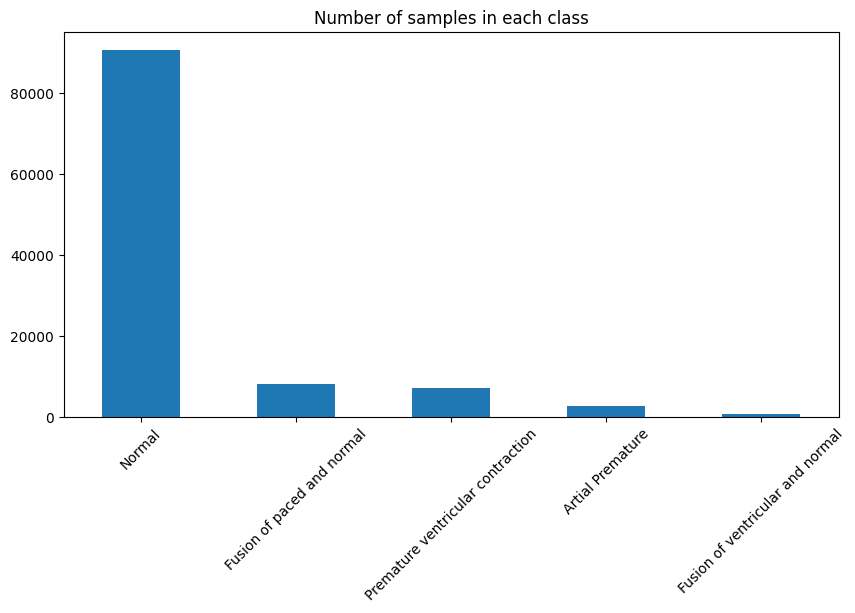

In [4]:
df_mitbih_train = pd.read_csv(f"{drive_path}/ecg_dataset/mitbih_train.csv", header = None)
df_mitbih_test = pd.read_csv(f"{drive_path}/ecg_dataset/mitbih_test.csv", header = None)

# print shapes of the dataframes
print("The shape of the mitbih_train is : ", df_mitbih_train.shape)
print("The shape of the mitbih_test is : ", df_mitbih_test.shape)

df_mitbih = pd.concat([df_mitbih_train, df_mitbih_test], axis=0)
df_mitbih.rename(columns={187: 'label'}, inplace=True)

id_to_label = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}
#df_mitbih['label'] = df_mitbih.iloc[:, -1].map(id_to_label)

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_mitbih.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_mitbih.columns = list(time) + ["label"]

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_mitbih["label"].value_counts()
# substitute the class names
counts.index = counts.index.map(id_to_label)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 45)
plt.title("Number of samples in each class")
plt.show()

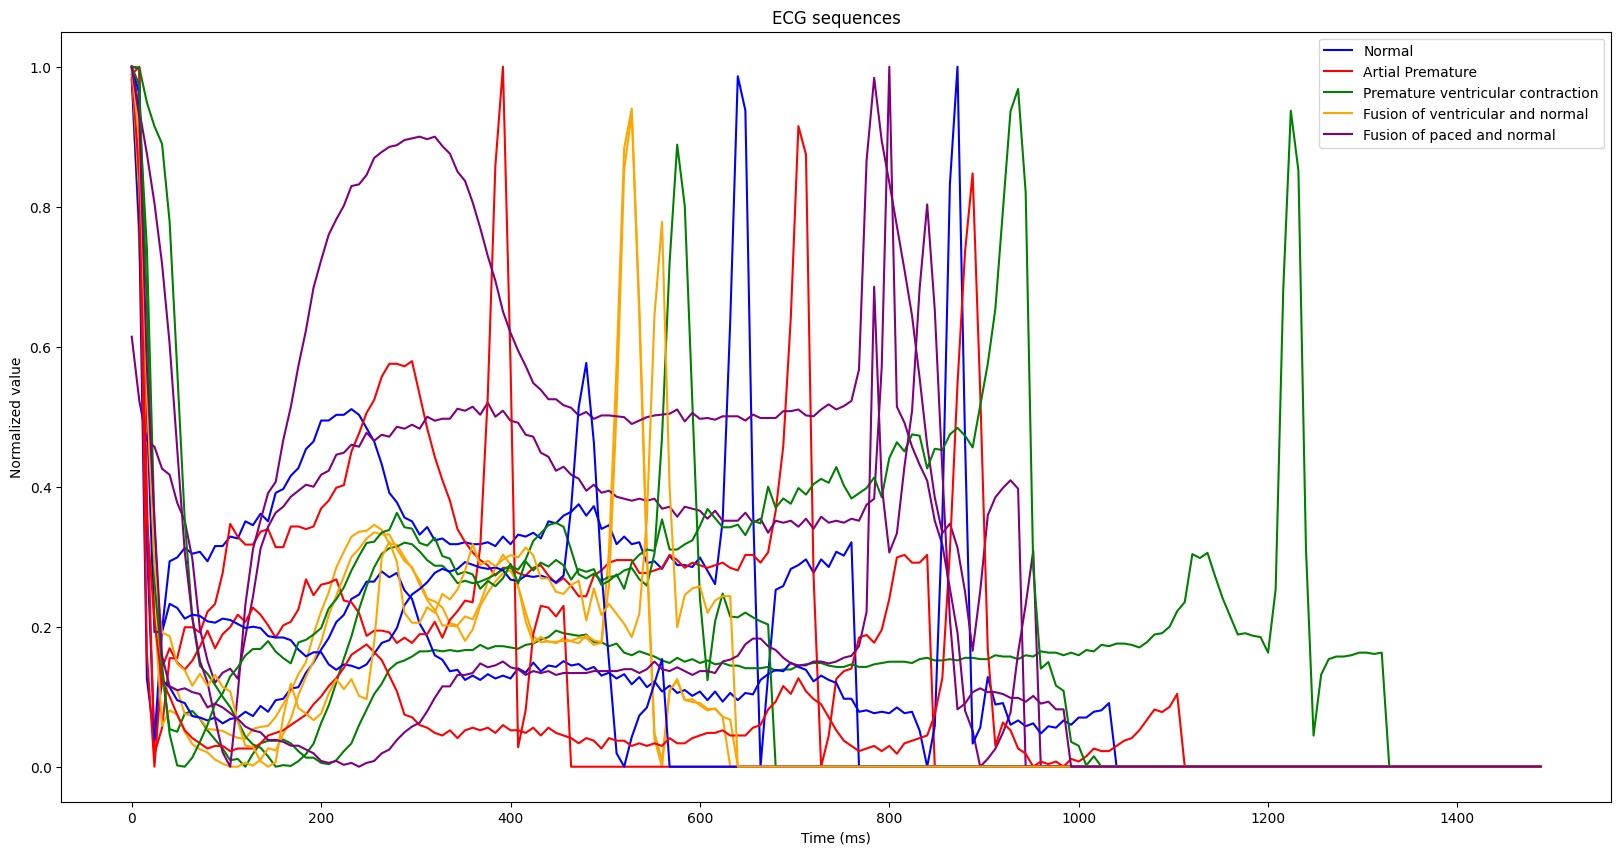

In [5]:
# create a figure
plt.figure(figsize = (20, 10))
# define colors for each class
colors = ["blue", "red", "green", "orange", "purple"]
# plot the normal sequences
for i in range(3):
    for label in id_to_label.keys():
        # sample a random sequence from that label
        df_mitbih_label = df_mitbih[df_mitbih["label"] == label].sample(1)
        # plot the sequence
        if i == 0:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], label = id_to_label[label], color = colors[label])
        else:
            plt.plot(df_mitbih_label.columns[:-1], df_mitbih_label.iloc[0, :-1], color = colors[label])
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Prepare your data: X as feature matrix and y as target variable
X_train = df_mitbih_train.iloc[:, :187].values

y_train = df_mitbih_train.iloc[:, 187].values

X_test = df_mitbih_test.iloc[:, :187].values

y_test = df_mitbih_test.iloc[:, 187].values

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'max_depth': 7,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': 5,
    'eval_metric': 'merror',  # Use multiclass classification error as evaluation metric
    'subsample': 0.8,  # Try values between 0.5 to 0.8
    'colsample_bytree': 0.8,  # Try values between 0.5 to 0.8
    'reg_alpha': 0.1,  # Try values between 0.01 to 0.1
    'reg_lambda': 0.1  # Try values between 0.01 to 0.1
}

# Train the XGBoost model
num_rounds = 150
early_stopping_rounds = 50  # Set early stopping to avoid overfitting
watchlist = [(dtrain, 'train'), (dtest, 'test')]
model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds=early_stopping_rounds)

# Make predictions on the testing set
y_pred = model.predict(dtest)

# Convert the predicted labels to integers
y_pred = np.asarray(y_pred, dtype=int)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[0]	train-merror:0.04016	test-merror:0.04540
[1]	train-merror:0.03673	test-merror:0.04107
[2]	train-merror:0.03422	test-merror:0.03928
[3]	train-merror:0.03254	test-merror:0.03878
[4]	train-merror:0.03106	test-merror:0.03709
[5]	train-merror:0.02991	test-merror:0.03604
[6]	train-merror:0.02835	test-merror:0.03517
[7]	train-merror:0.02684	test-merror:0.03385
[8]	train-merror:0.02509	test-merror:0.03184
[9]	train-merror:0.02404	test-merror:0.03147
[10]	train-merror:0.02280	test-merror:0.03047
[11]	train-merror:0.02106	test-merror:0.02923
[12]	train-merror:0.01998	test-merror:0.02869
[13]	train-merror:0.01850	test-merror:0.02796
[14]	train-merror:0.01729	test-merror:0.02777
[15]	train-merror:0.01649	test-merror:0.02750
[16]	train-merror:0.01544	test-merror:0.02700
[17]	train-merror:0.01460	test-merror:0.02668
[18]	train-merror:0.01385	test-merror:0.02627
[19]	train-merror:0.01293	test-merror:0.02576
[20]	train-merror:0.01216	test-merror:0.02544
[21]	train-merror:0.01156	test-merror:0.0250

In [7]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18118
         1.0       0.97      0.69      0.81       556
         2.0       0.97      0.93      0.95      1448
         3.0       0.90      0.74      0.81       162
         4.0       0.99      0.97      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.96      0.87      0.91     21892
weighted avg       0.98      0.98      0.98     21892



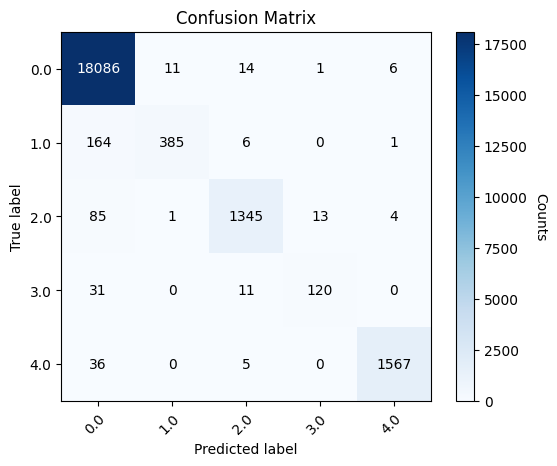

In [8]:
cm = confusion_matrix(y_test, y_pred)

# Get class labels
class_labels = unique_labels(y_test, y_pred)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the labels of the colorbar
cbar.ax.set_ylabel('Counts', rotation=-90, va="bottom")

# Set the tick marks and labels
tick_marks = np.arange(len(class_labels))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Set the axis labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

ax.set_title('Confusion Matrix')
plt.show()


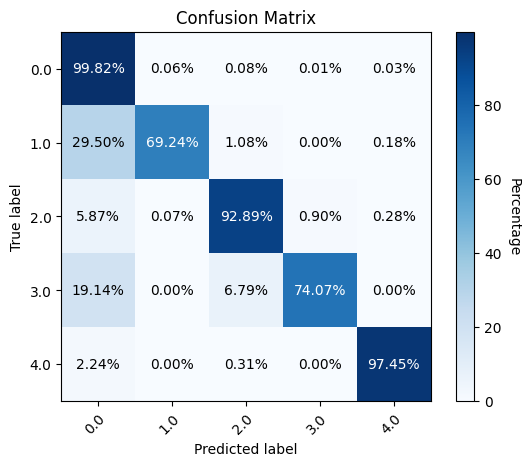

In [9]:
cm = confusion_matrix(y_test, y_pred)

# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Get class labels
class_labels = unique_labels(y_test, y_pred)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix
im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the labels of the colorbar
cbar.ax.set_ylabel('Percentage', rotation=-90, va="bottom")

# Set the tick marks and labels
tick_marks = np.arange(len(class_labels))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

# Set the axis labels
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Rotate the tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm_percent.shape[0]):
    for j in range(cm_percent.shape[1]):
        ax.text(j, i, f'{cm_percent[i, j]:.2f}%',
                ha="center", va="center",
                color="white" if cm_percent[i, j] > 50 else "black")

# Set the title
ax.set_title('Confusion Matrix')

# Display the plot
plt.show()